## 1. Setup

In [1]:
import sys
sys.path.append('../..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

from keras.callbacks import ModelCheckpoint, Callback
from neural_networks.unet import UNet
from neural_networks.keras_utils import EvalMetricsCallback
from utils.data.data_generator import DataGenerator
from utils.data.data_ops import move_val_split_to_train
from utils.data.data_ops import create_val_split_from_train
from utils.input_output.io import read_json, write_json
from utils.visualization.vis import plot_logs

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

## 2. Load the dataset

#### Create validation split from the initial training data

In [4]:
move_val_split_to_train(config.VAL_PATH, config.TRAIN_PATH)
create_val_split_from_train(config.TRAIN_PATH, config.VAL_PATH, config.VAL_SIZE, config.RAND_SEED)

In [5]:
train_params = {
    'dim': config.PATCH_DIM,
    'batch_size': config.BATCH_SIZE,
    'patches_per_image': config.PATCHES_PER_IMAGE,
    'density_map_multiplication_factor': config.DENSITY_MAP_MULTIPLICATION_FACTOR,
    'shuffle': config.SHUFFLE
}

val_params = {
    'dim': config.IMG_DIM,
    'batch_size': 1,
    'patches_per_image': 1,
    'density_map_multiplication_factor': config.DENSITY_MAP_MULTIPLICATION_FACTOR,
    'shuffle': False
}

eval_params = val_params.copy()

In [6]:
train_generator = DataGenerator(config.DATASET_PATH, 'train', **train_params)
val_generator = DataGenerator(config.DATASET_PATH, 'val', **val_params)

### for eval
train_generator_for_eval = DataGenerator(config.DATASET_PATH, 'train', **eval_params)
val_generator_for_eval = DataGenerator(config.DATASET_PATH, 'val', **eval_params)

## 3. Instantiate a UNet

In [7]:
model = UNet(loss_name=config.LOSS_NAME)

## 4. Train the model

In [8]:
!rm -rf $config.CHECKPOINTS_PATH
!rm -rf $config.LOGS_PATH
os.makedirs(config.CHECKPOINTS_PATH)
os.makedirs(config.LOGS_PATH)

In [9]:
%%time
eval_metrics_callback = EvalMetricsCallback(config.DENSITY_MAP_MULTIPLICATION_FACTOR,
                                            train_generator_for_eval,
                                            val_generator_for_eval)

model_checkpoint = ModelCheckpoint(config.CHECKPOINT_FILENAME,
                                   monitor='val_loss',
                                   save_best_only=True)

model_history = model.fit_generator(generator=train_generator,
                                    validation_data=val_generator,
                                    epochs=config.EPOCHS,
                                    callbacks=[model_checkpoint,
                                               eval_metrics_callback],
                                    verbose=1)

Epoch 1/100
16/16 [==============================] - 7s 468ms/step - loss: 0.0537 - val_loss: 0.0194
Epoch 2/100
16/16 [==============================] - 3s 206ms/step - loss: 0.0144 - val_loss: 0.0134
Epoch 3/100
16/16 [==============================] - 3s 207ms/step - loss: 0.0115 - val_loss: 0.0154
Epoch 4/100
16/16 [==============================] - 3s 208ms/step - loss: 0.0100 - val_loss: 0.0117
Epoch 5/100
16/16 [==============================] - 3s 208ms/step - loss: 0.0087 - val_loss: 0.0091
Epoch 6/100
16/16 [==============================] - 3s 207ms/step - loss: 0.0070 - val_loss: 0.0077
Epoch 7/100
16/16 [==============================] - 3s 208ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 8/100
16/16 [==============================] - 3s 209ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 9/100
16/16 [==============================] - 3s 209ms/step - loss: 0.0055 - val_loss: 0.0067
Epoch 10/100
16/16 [==============================] - 3s 210ms/step - loss: 0.0052 - val_lo

16/16 [==============================] - 3s 207ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 82/100
16/16 [==============================] - 3s 209ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 83/100
16/16 [==============================] - 3s 207ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 84/100
16/16 [==============================] - 3s 206ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 85/100
16/16 [==============================] - 3s 206ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 86/100
16/16 [==============================] - 3s 206ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 87/100
16/16 [==============================] - 3s 206ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 88/100
16/16 [==============================] - 3s 206ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 89/100
16/16 [==============================] - 3s 206ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 90/100
16/16 [==============================] - 3s 207ms/step - loss: 0.0017 - val_loss: 

#### Save and load train stats/logs/history

In [10]:
logs = model.history.history.copy()

logs['train_loss'] = logs.pop('loss')
logs['train_size'] = train_generator.get_size()
logs['val_size'] = val_generator.get_size()
logs['rand_seed'] = config.RAND_SEED
logs['shuffle'] = config.SHUFFLE
logs['loss_name'] = config.LOSS_NAME
logs['img_dim'] = config.IMG_DIM
logs['patch_dim'] = config.PATCH_DIM
logs['patches_per_image'] = config.PATCHES_PER_IMAGE
logs['density_map_sigma'] = config.GT_SIGMA
logs['density_map_multiplication_factor'] = config.DENSITY_MAP_MULTIPLICATION_FACTOR
logs['sub_experiment_name'] = config.SUB_EXPERIMENT_NAME
logs['architecture'] = config.ARCHITECTURE_NAME

min val_loss: 0.0041, epoch: 82


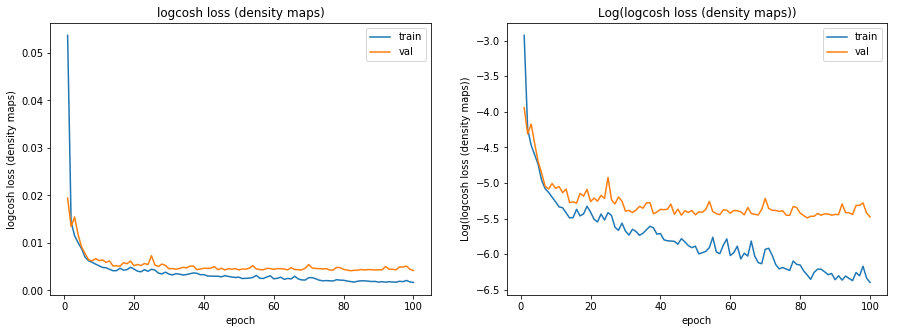

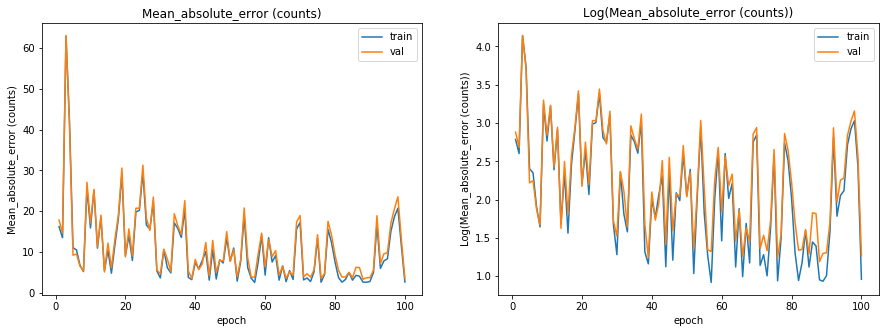

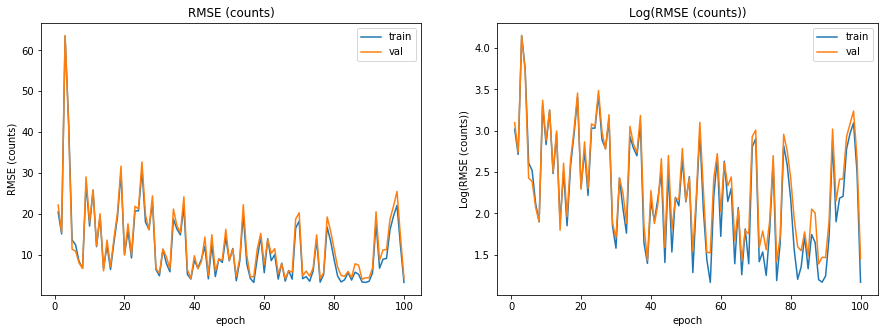

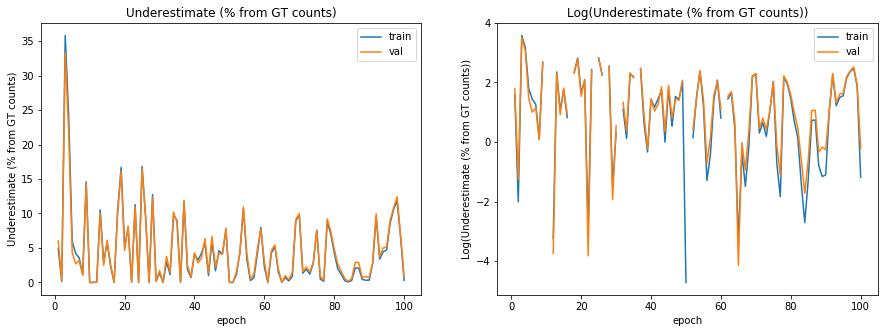

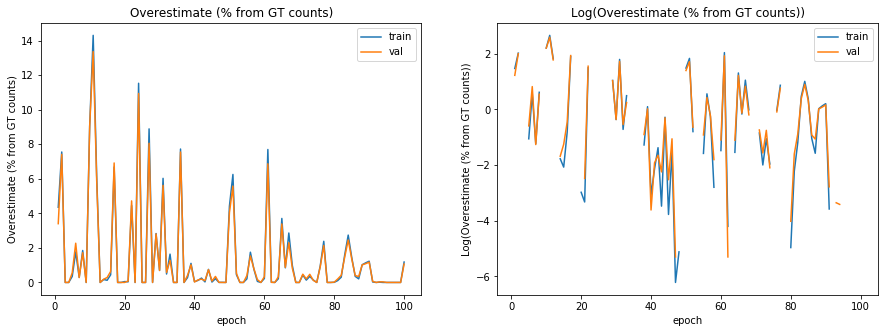

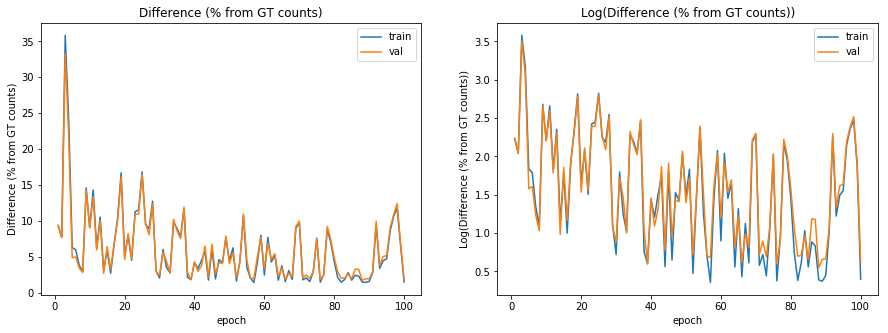

In [11]:
write_json(logs, config.LOGS_FILENAME)
logs = read_json(config.LOGS_FILENAME)

print(f'min val_loss: {np.min(logs["val_loss"]):.4f}, epoch: {1 + np.argmin(logs["val_loss"])}')

plot_logs(logs['train_loss'], logs['val_loss'], f'{config.LOSS_NAME} loss (density maps)')

plot_logs(logs['train_mae'], logs['val_mae'], f'Mean_absolute_error (counts)')
plot_logs(logs['train_rmse'], logs['val_rmse'], f'RMSE (counts)')
plot_logs(logs['train_underestimate'], logs['val_underestimate'], f'Underestimate (% from GT counts)')
plot_logs(logs['train_overestimate'], logs['val_overestimate'], f'Overestimate (% from GT counts)')
plot_logs(logs['train_difference'], logs['val_difference'], f'Difference (% from GT counts)')